In [16]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import unicodedata
import re
import pandas as pd
from sklearn.model_selection import train_test_split

2.2.0-rc1


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [ ]:
SAVE = True
NUM_EPOCHS = 20
BATCH_SIZE = 64
LSTM_SIZE = 512
EMBEDDING_SIZE = 256
SPLIT = 0.9
FILENAME = "Experiment_1/Data/CISTROME_no_protocol.csv"

In [ ]:
frame = pd.read_csv(FILENAME)
train_frame, test_frame = train_test_split(frame, train_size = SPLIT)
train_frame, val_frame = train_test_split(train_frame, train_size = SPLIT)
val = [[x.replace("("," ( ").replace(")", " ) ").replace("-",' - ').replace("_"," _ ").replace(";"," ; ").replace("  "," ").replace("=",""),'<start> ' + y.replace(" $",""), y.replace(" $","") + ' <end>'] for (x,y) in zip(val_frame.Input, val_frame.Output)]
train = [[x.replace("("," ( ").replace(")", " ) ").replace("-",' - ').replace("_"," _ ").replace(";"," ; ").replace("  "," ").replace("=",""),'<start> ' + y.replace(" $",""), y.replace(" $","") + ' <end>'] for (x,y) in zip(train_frame.Input, train_frame.Output)]
test = [[x.replace("("," ( ").replace(")", " ) ").replace("-",' - ').replace("_"," _ ").replace(";"," ; ").replace("  "," ").replace("=",""),'<start> ' + y.replace(" $",""), y.replace(" $","") + ' <end>'] for (x,y) in zip(test_frame.Input, test_frame.Output)]

In [ ]:
def tokenize_dataset(train, test, val, differentiate_vocabularies = False):
    tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='', lower=True, split=' ', char_level=False)
    for index in range(3):
        tokenizer.fit_on_texts(x[index] for x in train)
        tokenizer.fit_on_texts(x[index] for x in test)
        tokenizer.fit_on_texts(x[index] for x in val)
        
    train_in = tokenizer.texts_to_sequences(i[0] for i in train)
    train_in = tf.keras.preprocessing.sequence.pad_sequences(train_in, padding='post')
    train_outi = tokenizer.texts_to_sequences(i[1] for i in train)
    train_outi = tf.keras.preprocessing.sequence.pad_sequences(train_outi, padding='post')
    train_outo = tokenizer.texts_to_sequences(i[2] for i in train)
    train_outo = tf.keras.preprocessing.sequence.pad_sequences(train_outo, padding='post')

    test_in = tokenizer.texts_to_sequences(i[0] for i in test)
    test_in = tf.keras.preprocessing.sequence.pad_sequences(test_in, padding='post')
    test_outi = tokenizer.texts_to_sequences(i[1] for i in test)
    test_outi = tf.keras.preprocessing.sequence.pad_sequences(test_outi, padding='post')
    test_outo = tokenizer.texts_to_sequences(i[2] for i in test)
    test_outo = tf.keras.preprocessing.sequence.pad_sequences(test_outo, padding='post')
    
    val_in = tokenizer.texts_to_sequences(i[0] for i in val)
    val_in = tf.keras.preprocessing.sequence.pad_sequences(val_in, padding='post')
    val_outi = tokenizer.texts_to_sequences(i[1] for i in val)
    val_outi = tf.keras.preprocessing.sequence.pad_sequences(val_outi, padding='post')
    val_outo = tokenizer.texts_to_sequences(i[2] for i in val)
    val_outo = tf.keras.preprocessing.sequence.pad_sequences(val_outo, padding='post')


    return tokenizer,train_in, train_outi, train_outo, test_in, test_outi, test_outo, val_in, val_outi, val_outo

In [ ]:
tokenizer, train_in, train_outi, train_outo,
test_in, test_outi, test_outo,
val_in, val_outi, val_outo = tokenize_dataset(train,test,val)

training_set = tf.data.Dataset.from_tensor_slices((train_in,train_outi, train_outo))
training_set = training_set.shuffle(20).batch(BATCH_SIZE)

test_set = tf.data.Dataset.from_tensor_slices((test_in, test_outi, test_outo))
test_set = test_set.shuffle(20).batch(BATCH_SIZE)

val_set = tf.data.Dataset.from_tensor_slices((val_in, val_outi, val_outo))
val_set = val_set.shuffle(20).batch(BATCH_SIZE)

In [ ]:
class LuongAttention(tf.keras.Model):
    def __init__(self, rnn_size):
        super(LuongAttention, self).__init__()
        self.wa = tf.keras.layers.Dense(rnn_size)
        
    def call(self, decoder_output, encoder_output):
        # Dot score: h_t (dot) Wa (dot) h_s
        # encoder_output shape: (batch_size, max_len, rnn_size)
        # decoder_output shape: (batch_size, 1, rnn_size)
        # score will have shape: (batch_size, 1, max_len)
        score = tf.matmul(decoder_output, self.wa(encoder_output), transpose_b=True)
        # alignment vector a_t
        alignment = tf.nn.softmax(score, axis=2)
        context = tf.matmul(alignment, encoder_output)

        return context, alignment

class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, lstm_size):
        super(Encoder, self).__init__()
        self.lstm_size = lstm_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.lstm = tf.keras.layers.LSTM(
            lstm_size, return_sequences=True, return_state=True)

    def call(self, sequence, states):
        embed = self.embedding(sequence)
        output, state_h, state_c = self.lstm(embed, initial_state=states)

        return output, state_h, state_c

    def init_states(self, batch_size):
        return (tf.zeros([batch_size, self.lstm_size]),
                tf.zeros([batch_size, self.lstm_size]))

#DECODER FOR ATTENTION
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, rnn_size):
        super(Decoder, self).__init__()
        
        # Create a LuongAttention object
        self.attention = LuongAttention(rnn_size)

        self.rnn_size = rnn_size
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.lstm = tf.keras.layers.LSTM(
            rnn_size, return_sequences=True, return_state=True)
        self.wc = tf.keras.layers.Dense(rnn_size, activation='tanh')
        self.ws = tf.keras.layers.Dense(vocab_size)
        
    def call(self, sequence, state, encoder_output):
        # Remember that the input to the decoder
        # is now a batch of one-word sequences,
        # which means that its shape is (batch_size, 1)
        embed = self.embedding(sequence)
        
        # Therefore, the lstm_out has shape (batch_size, 1, rnn_size)
        lstm_out, state_h, state_c = self.lstm(embed, initial_state=state)
        # Use self.attention to compute the context and alignment vectors
        # context vector's shape: (batch_size, 1, rnn_size)
        # alignment vector's shape: (batch_size, 1, source_length)
        context, alignment = self.attention(lstm_out, encoder_output)
        # Combine the context vector and the LSTM output
        # Before combined, both have shape of (batch_size, 1, rnn_size),
        # so let's squeeze the axis 1 first
        # After combined, it will have shape of (batch_size, 2 * rnn_size)
        lstm_out = tf.concat([tf.squeeze(context, 1), tf.squeeze(lstm_out, 1)], 1)
        
        # lstm_out now has shape (batch_size, rnn_size)
        lstm_out = self.wc(lstm_out)
        
        # Finally, it is converted back to vocabulary space: (batch_size, vocab_size)
        logits = self.ws(lstm_out)

        return logits, state_h, state_c, alignment

def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True)
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss



In [ ]:
#TRAIN FOR ATTENTION
@tf.function
def train_step(source_seq, target_seq_in, target_seq_out, en_initial_states):
    loss = 0
    with tf.GradientTape() as tape:
        en_outputs = encoder(source_seq, en_initial_states)
        en_states = en_outputs[1:]
        de_state_h, de_state_c = en_states
        
        # We need to create a loop to iterate through the target sequences
        for i in range(target_seq_out.shape[1]):
            # Input to the decoder must have shape of (batch_size, length)
            # so we need to expand one dimension
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
            logit, de_state_h, de_state_c, _ = decoder(decoder_in, (de_state_h, de_state_c), en_outputs[0])
            
            # The loss is now accumulated through the whole batch
            loss += loss_func(target_seq_out[:, i], logit)

    variables = encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, variables)
    optimizer.apply_gradients(zip(gradients, variables))

    return loss / target_seq_out.shape[1]
    
#TEST FOR ATTENTION
@tf.function
def test_step(source_seq, target_seq_in, target_seq_out, en_initial_states):
    loss = 0
    with tf.GradientTape() as tape:
        en_outputs = encoder(source_seq, en_initial_states)
        en_states = en_outputs[1:]
        de_state_h, de_state_c = en_states
        
        # We need to create a loop to iterate through the target sequences
        for i in range(target_seq_out.shape[1]):
            # Input to the decoder must have shape of (batch_size, length)
            # so we need to expand one dimension
            decoder_in = tf.expand_dims(target_seq_in[:, i], 1)
            logit, de_state_h, de_state_c, _ = decoder(
                decoder_in, (de_state_h, de_state_c), en_outputs[0])
            
            # The loss is now accumulated through the whole batch
            loss += loss_func(target_seq_out[:, i], logit)

    return loss / target_seq_out.shape[1]

#PREDICT FOR ATTENTION
def predict(test_source_text=None):
    choice = np.random.choice(len(test))
    if test_source_text is None:
        test_source_text = test[choice][0]
        target_text = test[choice][2].split(" ")
    print(test_source_text)
    print("TARGET")
    print(' '.join(target_text))   
    test_source_seq = tokenizer.texts_to_sequences([test_source_text])

    en_initial_states = encoder.init_states(1)
    en_outputs = encoder(tf.constant(test_source_seq), en_initial_states)

    de_input = tf.constant([[tokenizer.word_index['<start>']]])
    de_state_h, de_state_c = en_outputs[1:]
    out_words = []
    alignments = []

    while True:
        de_output, de_state_h, de_state_c, alignment = decoder(
            de_input, (de_state_h, de_state_c), en_outputs[0])
        de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
        
        out_words.append(tokenizer.index_word[de_input.numpy()[0][0]])
        alignments.append(alignment.numpy())     
        if out_words[-1] == '<end>' or len(out_words) >= 100:
            break
        
    print("PREDICTED")
    print(' '.join(out_words))

In [ ]:
optimizer = tf.keras.optimizers.Adam()
in_vocab_size = len(tokenizer.word_index) + 1
out_vocab_size = len(tokenizer.word_index) + 1

encoder = Encoder(in_vocab_size, EMBEDDING_SIZE, LSTM_SIZE)
decoder = Decoder(out_vocab_size, EMBEDDING_SIZE, LSTM_SIZE)  
  
test_losses = []
training_losses = []
for e in range(NUM_EPOCHS):
    en_initial_states = encoder.init_states(BATCH_SIZE)
    training_loss = 0.0
    training_samples = 0.0
    for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(training_set.take(-1)):
        if(len(source_seq)== BATCH_SIZE):
            training_loss += train_step(source_seq, target_seq_in, target_seq_out, en_initial_states)
            training_samples += 1
        
        
    print("Training complete, now validating...")
    training_loss = training_loss/training_samples
    if(e == 0):
        old_val_loss == 999
    else:
        old_val_loss = val_loss
    val_loss = 0.0
    val_samples = 0.0
    for batch, (source_seq, target_seq_in, target_seq_out) in enumerate(val_set.take(-1)):
        if(len(source_seq) == BATCH_SIZE):
            val_loss += test_step(source_seq, target_seq_in,
                                    target_seq_out, en_initial_states)
            val_samples += 1
        
    val_loss = val_loss/val_samples
    
    print(f"Old validation loss =  {old_val_loss}, new validation loss = {val_loss}...")
    if(val_loss > old_val_loss):
        print("Validation loss increased, breaking training...")
        break
    print('Epoch {} Training Loss {:.4f}, Val Loss {:.4f}'.format(e + 1, training_loss.numpy(), val_loss.numpy()))
    try:
        predict()
    except Exception:
        continue
    training_losses.append(training_loss)
    val_losses.append(val_loss)
    

Training complete, now testing...
Epoch 1 Training Loss 1.8006, Test Loss 0.8440
Title: 24h - diff - WT _ H3K27me1 _ rep1 - Description: developmental stage: 24 hours differentiated ES cells ; chip antibody: H3K27me1 ( Millipore, 07 - 448, lot unknown ) ; strain: E14 - Characteristics: Mus musculus
TARGET
Cell Line: None - Cell Type: Embryonic Stem Cell - Tissue Type: None - Factor: H3K27me1 <end>
PREDICTED
cell line: none - tissue type: none - factor: h3k4me3 <end>
Training complete, now testing...
Epoch 2 Training Loss 0.7432, Test Loss 0.7002
Title: Broad _ ChipSeq _ A549 _ H3K36me3 _ DEX _ 100nM - Description: datatype: ChipSeq ; datatype description: Chromatin IP Sequencing ; antibody antibodydescription: rabbit polyclonal. Antibody Target: H3K36me3 ; antibody targetdescription: Specific for histone H3 tri methylated at lysine 36, weakly reacts with H3K36me2. Marks regions of RNAPII elongation, including coding and non - coding transcripts. ; antibody vendorname: abcam ; antibody 

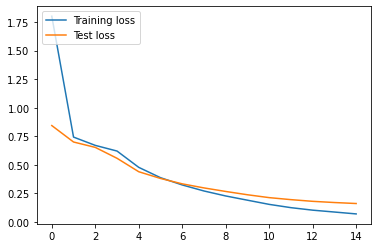

In [ ]:
import matplotlib.pyplot as plt
x = np.arange(NUM_EPOCHS)
plt.plot(x, training_losses)
plt.plot(x, val_losses)
plt.legend(["Training loss", "Val loss"], loc = "upper left")
plt.show()

## TESTING MODEL

In [ ]:
results = []
for index in range(len(test)):
    
    choice = index
    test_source_text = test[choice][0]
    target_text = test[choice][2]
    test_source_seq = tokenizer.texts_to_sequences([test_source_text])

    en_initial_states = encoder.init_states(1)
    en_outputs = encoder(tf.constant(test_source_seq), en_initial_states)
    
    de_input = tf.constant([[tokenizer.word_index['<start>']]])
      
    de_state_h, de_state_c = en_outputs[1:]
    out_words = []
    alignments = []

    while True:
        de_output, de_state_h, de_state_c, alignment = decoder(
            de_input, (de_state_h, de_state_c), en_outputs[0])
        de_input = tf.expand_dims(tf.argmax(de_output, -1), 0)
        out_words.append(tokenizer.index_word[de_input.numpy()[0][0]])
        alignments.append(alignment.numpy())
        
        if out_words[-1] == '<end>' or len(out_words) >= 100:
              break

    results.append([test_source_text,target_text, ' '.join(out_words)])


dataframe_results = pd.DataFrame(results, columns = ["Text","Target", "Predicted"])
# if(SAVE):
#     dataframe_results.to_csv(f"Experiment_2/Results/LSTM_results_{NUM_EPOCHS}epochs.csv")
dataframe_results

,Text,Target,Predicted
0,Title: UACC812.H3K9ac.rep1 - Description: cell...,Cell Line: UACC812 - Cell Type: None - Tissue ...,cell line: v481 - cell type: stem cell - tissu...
1,Title: 786O _ H3K27ac _ 2 - Description: cell ...,Cell Line: 786-O - Cell Type: Epithelium - Tis...,cell line: 786-o - cell type: epithelium - tis...
2,Title: K562 _ H4K20me1 _ rep1 - Description: c...,Cell Line: K562 - Cell Type: Erythroblast - Ti...,cell line: k562 - cell type: erythroblast - ti...
3,Title: Anti - PolII - S5 - Description: strain...,Cell Line: None - Cell Type: T Lymphocyte - Ti...,cell line: none - cell type: monocyte - tissue...
4,Title: p300S4KO _ 2 - Description: strain: C57...,Cell Line: None - Cell Type: T Lymphocyte - Ti...,cell line: none - cell type: t lymphocyte - ti...
...,...,...,...
8509,Title: miwi2KO _ GermCellsTestis _ MACS _ H3K9...,Cell Line: None - Cell Type: Germ Cell - Tissu...,cell line: none - cell type: germ cell - tissu...
8510,Title: BJ1 ZFP57 - Description: strain: BJ1 ; ...,Cell Line: None - Cell Type: Embryonic Stem Ce...,cell line: none - cell type: embryonic stem ce...
8511,Title: ChIPSeq _ Wap - delE3 _ L1 _ H3K27ac _ ...,Cell Line: None - Cell Type: None - Tissue Typ...,cell line: none - tissue type: bone marrow - f...
8512,Title: ChIP:TASOR _ Cell:MORC2 - KO _ rep1 - D...,Cell Line: K562 - Cell Type: Leukemia - Tissue...,cell line: k562 - cell type: leukemia - tissue...


In [ ]:
dataframe_results.to_csv(f"Results/LSTM_{e}epochs.csv")